In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from itertools import combinations, product
import matplotlib
from matplotlib import pyplot as plt
# plt.rcParams['figure.figsize']=(20,10)
# plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM, Dropout, Bidirectional, Conv2D, MaxPooling2D

In [3]:
deaths_df = pd.read_csv('../combined_data.csv', index_col=0)
# deaths_df = df.drop(['new_confirmed_cases'], axis=1).iloc[35:]
deaths_df.head()

,Date,no2,ozone,pm25,County,new_deaths
0,2020-01-26,0.015,0.034,7.3,Alameda,0.0
1,2020-01-27,0.024,0.032,9.9,Alameda,0.0
2,2020-01-28,0.025,0.033,9.7,Alameda,0.0
3,2020-01-29,0.022,0.024,11.8,Alameda,0.0
4,2020-01-30,0.022,0.021,10.2,Alameda,0.0


/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in reciprocal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='new_deaths', ylabel='Density'>

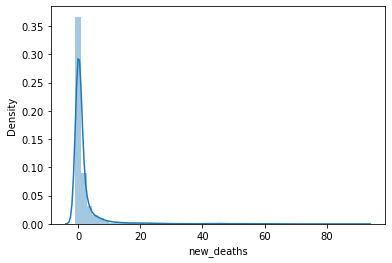

In [4]:
from scipy import stats
deaths = deaths_df['new_deaths']
# deaths = deaths.replace(-1.0, 0)

log = np.log(deaths)
log = log.replace(-np.Inf, 0)
# sns.distplot(log)

rec = np.reciprocal(deaths)
rec = rec.replace(np.Inf, np.nan)
# sns.distplot(rec)

# square = np.power(deaths)
sns.distplot(deaths)

In [5]:
def nth_day_feature(df, feature, n):
    rows = df.shape[0]
    nth_prior_measurement = [None]*n + [df[feature][i-n] for i in range(n, rows)]
    col_name = f'{feature}_{n}'
    df[col_name] = nth_prior_measurement

In [6]:
for feature in deaths_df.columns:
    if 'Date' in feature:
        continue
    if 'County' in feature:
        continue
    for n in range(1,21):
        nth_day_feature(deaths_df, feature, n)

In [7]:
deaths_df.head()

,Date,no2,ozone,pm25,County,new_deaths,no2_1,no2_2,no2_3,no2_4,...,new_deaths_11,new_deaths_12,new_deaths_13,new_deaths_14,new_deaths_15,new_deaths_16,new_deaths_17,new_deaths_18,new_deaths_19,new_deaths_20
0,2020-01-26,0.015,0.034,7.3,Alameda,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-27,0.024,0.032,9.9,Alameda,0.0,0.015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-28,0.025,0.033,9.7,Alameda,0.0,0.024,0.015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-29,0.022,0.024,11.8,Alameda,0.0,0.025,0.024,0.015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-30,0.022,0.021,10.2,Alameda,0.0,0.022,0.025,0.024,0.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
deaths_df = pd.get_dummies(deaths_df, columns=['County'])
deaths_df

,Date,no2,ozone,pm25,new_deaths,no2_1,no2_2,no2_3,no2_4,no2_5,...,County_San_Mateo,County_Santa_Barbara,County_Santa_Clara,County_Solano,County_Sonoma,County_Stanislaus,County_Sutter,County_Tulare,County_Ventura,County_Yolo
0,2020-01-26,0.015,0.034,7.3,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-27,0.024,0.032,9.9,0.0,0.015,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-28,0.025,0.033,9.7,0.0,0.024,0.015,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-29,0.022,0.024,11.8,0.0,0.025,0.024,0.015,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-30,0.022,0.021,10.2,0.0,0.022,0.025,0.024,0.015,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10139,2020-12-03,0.010,0.020,24.1,0.0,0.012,0.008,0.008,0.010,0.006,...,0,0,0,0,0,0,0,0,0,1
10140,2020-12-04,0.010,0.019,16.4,0.0,0.010,0.012,0.008,0.008,0.010,...,0,0,0,0,0,0,0,0,0,1
10141,2020-12-05,0.004,0.020,25.4,3.0,0.010,0.010,0.012,0.008,0.008,...,0,0,0,0,0,0,0,0,0,1
10142,2020-12-06,0.005,0.024,19.1,0.0,0.004,0.010,0.010,0.012,0.008,...,0,0,0,0,0,0,0,0,0,1


In [9]:
to_remove = ['no2', 'pm25', 'ozone', 'County']
to_keep = [col for col in deaths_df.columns if col not in to_remove]
df = deaths_df[to_keep]
df.columns

Index(['Date', 'new_deaths', 'no2_1', 'no2_2', 'no2_3', 'no2_4', 'no2_5',
       'no2_6', 'no2_7', 'no2_8',
       ...
       'County_San_Mateo', 'County_Santa_Barbara', 'County_Santa_Clara',
       'County_Solano', 'County_Sonoma', 'County_Stanislaus', 'County_Sutter',
       'County_Tulare', 'County_Ventura', 'County_Yolo'],
      dtype='object', length=114)

In [10]:
spread = df.describe().T

IQR = spread['75%'] - spread['25%']
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))
spread.loc[spread.outliers]

,count,mean,std,min,25%,50%,75%,max,outliers
new_deaths,10144.0,1.943513,6.388663,-1.0,0.000,0.000,1.000,91.00,True
no2_1,10143.0,0.009788,0.008464,0.0,0.004,0.007,0.013,0.06,True
no2_2,10142.0,0.009788,0.008465,0.0,0.004,0.007,0.013,0.06,True
no2_3,10141.0,0.009789,0.008465,0.0,0.004,0.007,0.013,0.06,True
no2_4,10140.0,0.009789,0.008465,0.0,0.004,0.007,0.013,0.06,True
...,...,...,...,...,...,...,...,...,...
County_Stanislaus,10144.0,0.031250,0.174001,0.0,0.000,0.000,0.000,1.00,True
County_Sutter,10144.0,0.031250,0.174001,0.0,0.000,0.000,0.000,1.00,True
County_Tulare,10144.0,0.031250,0.174001,0.0,0.000,0.000,0.000,1.00,True
County_Ventura,10144.0,0.031250,0.174001,0.0,0.000,0.000,0.000,1.00,True


In [11]:
df = df.dropna()
df

,Date,new_deaths,no2_1,no2_2,no2_3,no2_4,no2_5,no2_6,no2_7,no2_8,...,County_San_Mateo,County_Santa_Barbara,County_Santa_Clara,County_Solano,County_Sonoma,County_Stanislaus,County_Sutter,County_Tulare,County_Ventura,County_Yolo
20,2020-02-15,0.0,0.018,0.018,0.028,0.033,0.027,0.005,0.015,0.024,...,0,0,0,0,0,0,0,0,0,0
21,2020-02-16,0.0,0.020,0.018,0.018,0.028,0.033,0.027,0.005,0.015,...,0,0,0,0,0,0,0,0,0,0
22,2020-02-17,0.0,0.014,0.020,0.018,0.018,0.028,0.033,0.027,0.005,...,0,0,0,0,0,0,0,0,0,0
23,2020-02-18,0.0,0.022,0.014,0.020,0.018,0.018,0.028,0.033,0.027,...,0,0,0,0,0,0,0,0,0,0
24,2020-02-19,0.0,0.032,0.022,0.014,0.020,0.018,0.018,0.028,0.033,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10139,2020-12-03,0.0,0.012,0.008,0.008,0.010,0.006,0.006,0.001,0.004,...,0,0,0,0,0,0,0,0,0,1
10140,2020-12-04,0.0,0.010,0.012,0.008,0.008,0.010,0.006,0.006,0.001,...,0,0,0,0,0,0,0,0,0,1
10141,2020-12-05,3.0,0.010,0.010,0.012,0.008,0.008,0.010,0.006,0.006,...,0,0,0,0,0,0,0,0,0,1
10142,2020-12-06,0.0,0.004,0.010,0.010,0.012,0.008,0.008,0.010,0.006,...,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:>

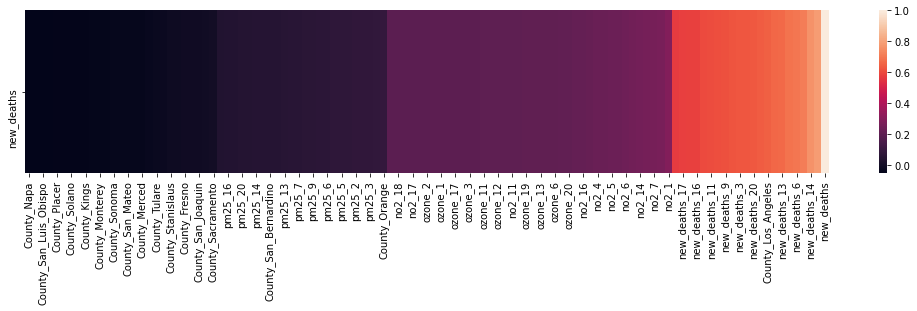

In [38]:
df_corr = df.corr()[['new_deaths']].sort_values('new_deaths')
plt.figure(figsize=(18,3))
sns.heatmap(df_corr.T)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta

In [17]:
dt = (datetime.strptime(df['Date'].iloc[-1], '%Y-%m-%d') - datetime.strptime(df['Date'].iloc[0], '%Y-%m-%d')).days
val_split = int(dt * .8)
val_split_date = datetime.strptime(df['Date'].iloc[0], '%Y-%m-%d') + timedelta(days=val_split)
val_split_date_str = datetime.strftime(val_split_date, '%Y-%m-%d')
test_split = int(dt * .9)
test_split_date = datetime.strptime(df['Date'].iloc[0], '%Y-%m-%d') + timedelta(days=test_split)
test_split_date_str = datetime.strftime(test_split_date, '%Y-%m-%d')


In [20]:
X = df[[col for col in df.columns if col != 'new_deaths']]
y = df[['new_deaths', 'Date']]
X_train = X[X['Date'] < test_split_date_str]
X_test = X[X['Date'] > test_split_date_str]
y_train = y[y['Date'] < test_split_date_str]
y_test = y[y['Date'] > test_split_date_str]

X_train.drop('Date', axis=1, inplace=True)
X_test.drop('Date', axis=1, inplace=True)
y_train.drop('Date', axis=1, inplace=True)
y_test.drop('Date', axis=1, inplace=True)

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
prediction = regressor.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f deaths" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f deaths" % median_absolute_error(y_test, prediction))

The Explained Variance: 0.68
The Mean Absolute Error: 1.71 deaths
The Median Absolute Error: 0.83 deaths


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
    
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
# Perform K-Fold CV
scores = cross_val_score(rfr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/

In [24]:
rfr.fit(X_train, y_train)

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(max_depth=6, n_estimators=50, random_state=False,
                      verbose=False)

In [25]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
prediction = rfr.predict(X_test)
print("The Explained Variance: %.2f" % rfr.score(X_test, y_test))
print("The Mean Absolute Error: %.2f deaths" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f deaths" % median_absolute_error(y_test, prediction))

The Explained Variance: 0.68
The Mean Absolute Error: 1.55 deaths
The Median Absolute Error: 0.54 deaths


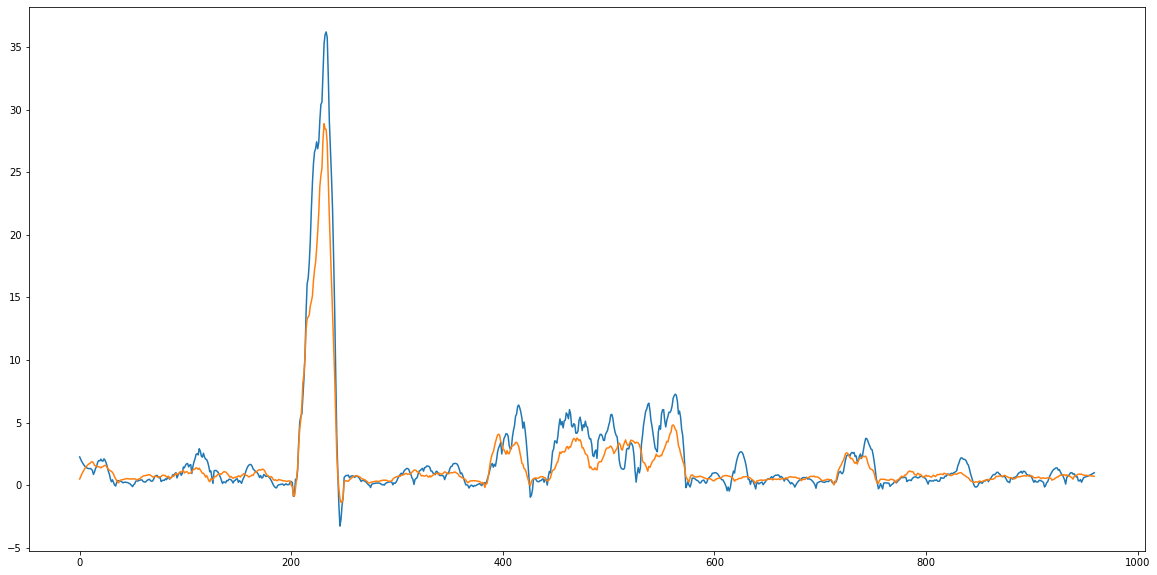

In [53]:
from scipy.signal import savgol_filter
smooth_pred = savgol_filter(prediction.ravel(), 21, 2)
smooth_y = savgol_filter(y_test['new_deaths'].values.ravel(), 21, 2)

y_actual = y_test['new_deaths'].values
plt.rcParams['figure.figsize'] = [20,10]
# plot results
# plt.plot(y_actual)
# plt.plot(prediction)

# plot smoothed
# plt.plot(smooth_y[350:550])
# plt.plot(smooth_pred[350:550])
plt.plot(smooth_y)
plt.plot(smooth_pred)

# plot differences
# plt.fill_between(range(0,len(smooth_pred)), prediction, y_actual, where=y_actual >= prediction, facecolor='green')
# plt.fill_between(range(0,len(smooth_pred)), prediction, y_actual, where=y_actual <= prediction, facecolor='red')
plt.show()

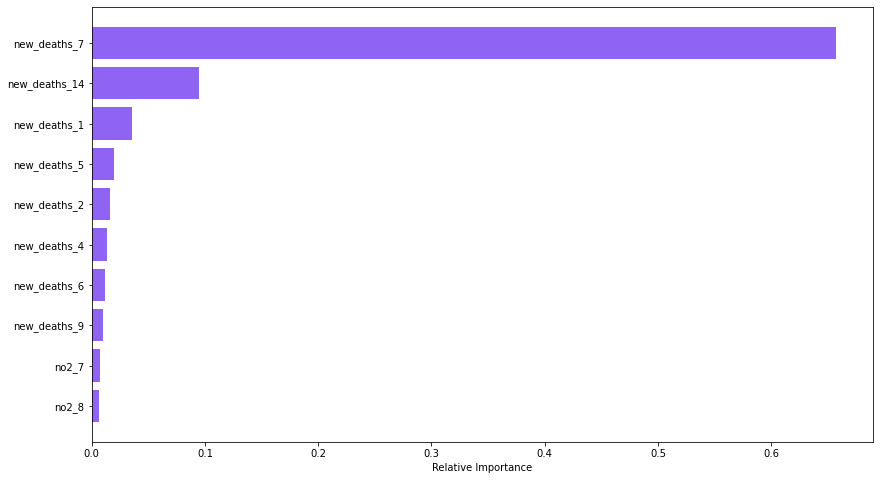

In [332]:
features = X_train.columns.values
importances = rfr.feature_importances_
indices = np.argsort(importances)[-10:]

plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()